In [1]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import h5py
import matplotlib.pyplot as plt
from scipy.optimize import leastsq,curve_fit

In [2]:
#analysis_master_path='Y:/Rb/Analysis/' # Y:\ is network drive connected to Hexagon E:\Rb\

exp_id='2018_06_18_11_26_27_Red Y alignment'
data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
exp_path=data_master_path+exp_date+'/'+exp_id+'/'
experiment_file='results.hdf5'
dp=exp_path
cuts = [[450],[450],[450]]

q = qdp.QDP(base_data_path=dp)
q.load_data_file(experiment_file)
for r in range(5):
    q.set_thresholds(cuts, roi=r)

In [3]:
q.experiments[0]['variable_list']
xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
q.get_thresholds()
retention = q.apply_thresholds()
#np.squeeze(retention['retention'])

In [4]:
tbl_str = "ivar:\t{0:.2f}\tretention:{1:.3f} +- {2:.3f}"
for i in range(len(retention['retention'].flatten())):
    print(tbl_str.format(
        retention['ivar'].flatten()[i],
        retention['retention'].flatten()[i],
        retention['error'].flatten()[i]
    ))

ivar:	-200.00	retention:0.879 +- 0.035
ivar:	-200.00	retention:0.842 +- 0.035
ivar:	-200.00	retention:0.892 +- 0.035
ivar:	-200.00	retention:0.860 +- 0.035
ivar:	-200.00	retention:0.737 +- 0.035
ivar:	-160.00	retention:0.550 +- 0.045
ivar:	-160.00	retention:0.844 +- 0.045
ivar:	-160.00	retention:0.820 +- 0.045
ivar:	-160.00	retention:0.679 +- 0.045
ivar:	-160.00	retention:0.600 +- 0.045
ivar:	-120.00	retention:0.667 +- 0.039
ivar:	-120.00	retention:0.860 +- 0.039
ivar:	-120.00	retention:0.820 +- 0.039
ivar:	-120.00	retention:0.744 +- 0.039
ivar:	-120.00	retention:0.769 +- 0.039
ivar:	-80.00	retention:0.710 +- 0.060
ivar:	-80.00	retention:0.438 +- 0.060
ivar:	-80.00	retention:0.880 +- 0.060
ivar:	-80.00	retention:0.788 +- 0.060
ivar:	-80.00	retention:0.727 +- 0.060
ivar:	-40.00	retention:0.667 +- 0.054
ivar:	-40.00	retention:0.414 +- 0.054
ivar:	-40.00	retention:0.820 +- 0.054
ivar:	-40.00	retention:0.794 +- 0.054
ivar:	-40.00	retention:0.200 +- 0.054
ivar:	0.00	retention:0.733 +- 0.049

In [5]:
def sin(t,amp,freq,phase,offset):
    res = (amp*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def decaying_sin(t,tau,amp,freq,phase,offset):
    res = (amp*np.exp(-t/tau)*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def est_freq(ydata,tgap,tau,amp,freq,phase,offset): # Estimation of frequency change (from dy/df where y=sinusoidal fit)
    res=(ydata-decaying_sin(tau,tgap,amp,freq,phase,offset))/(amp*np.exp(-tgap/tau)*2*np.pi*tgap*np.cos(2*np.pi*freq*tgap+phase))
    return res

def gaussian(x,amp,x0,sigma,offset):
    res=(amp*np.exp((-(x-x0)**2)/(sigma**2)))+offset
    return res

<IPython.core.display.Javascript object>


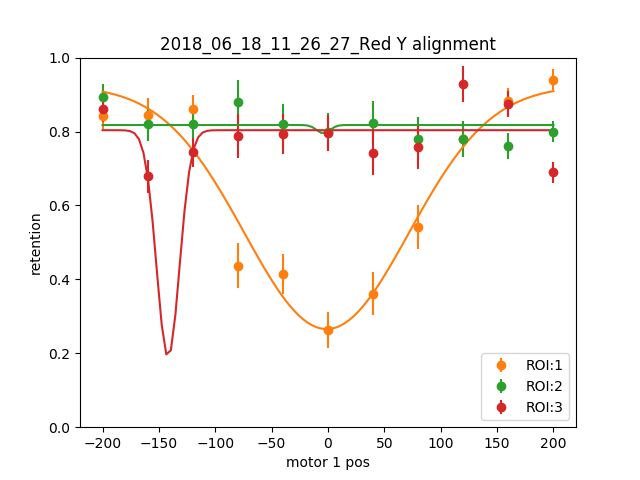

[-1, 0, 30, 1]
ROI:1, amplitude : -0.658108508823, location: -1.20941970377 , sigma:102.905151585, offset:0.923604056168
[-1, 0, 30, 1]
ROI:2, amplitude : -0.0224688397399, location: -4.12029108586 , sigma:8.32592938683, offset:0.817583708627
[-1, 0, 30, 1]
ROI:3, amplitude : -0.61360383167, location: -141.891634688 , sigma:-14.3562151732, offset:0.803573610969


In [8]:
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = plt.subplots()
fit_guesses=[-1,0,30,1]
roi_dependency=[0,0,0,0]
fitted_parameters=[]
for roi in [1,2,3]:
    #fit_guesses=[-1,(-50)+100*(roi-1),10,1]
    #fit_guesses=[-1,0,30,1]
    print fit_guesses
    data = []
    reten = []
    err = []
    for e in range(len(np.squeeze(retention['ivar']))):
        data.append(np.squeeze(retention['ivar'])[e][roi])
        reten.append(np.squeeze(retention['retention'])[e][roi])
        err.append(np.squeeze(retention['error'])[e][roi])
    ax.errorbar(data,reten,yerr=err,label="ROI:{}".format(roi),fmt='o',color=colors[roi])
    guesses=np.add(fit_guesses,np.ones(len(fit_guesses))*(roi-2)*roi_dependency)
    fit = curve_fit(gaussian,data,reten,guesses)
    print "ROI:{}, amplitude : {}, location: {} , sigma:{}, offset:{}".format(roi,fit[0][0],fit[0][1],fit[0][2],fit[0][3])
    fitted_parameters.append(fit[0])
    #print fit[0]
    xarray=np.linspace(np.min(data),np.max(data),100)
    yfit=gaussian(xarray, np.float(fit[0][0]),np.float(fit[0][1]),np.float(fit[0][2]),np.float(fit[0][3]))
    plt.plot(xarray,yfit,color=colors[roi])

plt.show()
ax.set_title(exp_id)
ax.set_ylim(0, 1)
ax.set_xlabel(xlab)
ax.set_ylabel('retention')
ax.legend()

<IPython.core.display.Javascript object>


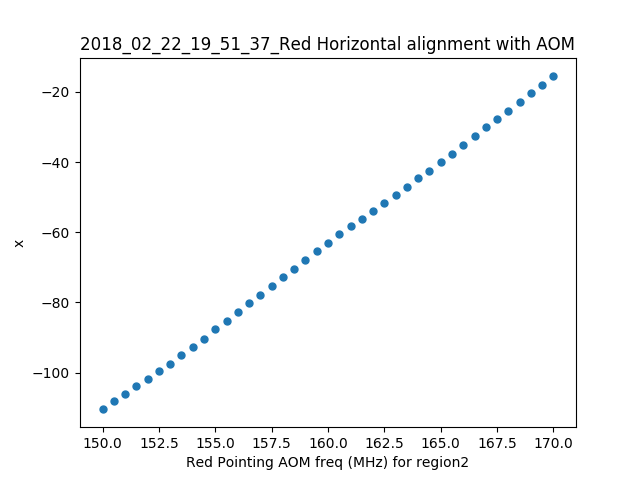

C:\Users\Rb\AppData\Local\Enthought\Canopy\User\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [7]:
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = plt.subplots()
xdata = []
ydata = []
yerr = []
for e in range(len(np.squeeze(retention['ivar']))):
    xdata.append(np.squeeze(retention['ivar'])[e][2])
    ydata.append(q.experiments[0]['iterations'][e]['AAS_redside']['x'])
    yerr.append(q.experiments[0]['iterations'][e]['AAS_redside']['sigma_x'])
ax.errorbar(xdata,ydata,yerr=yerr,fmt='o',markersize=5)

plt.show()
ax.set_title(exp_id)
#ax.set_ylim(-10, 10)
ax.set_xlabel(xlab)
ax.set_ylabel('x')
ax.legend()

<IPython.core.display.Javascript object>


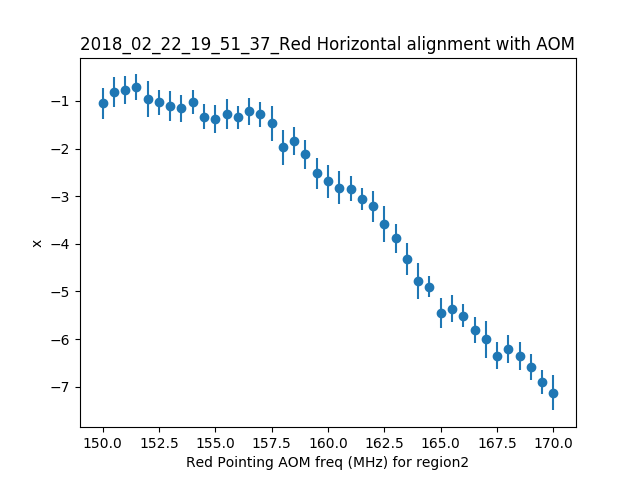

In [8]:
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = plt.subplots()
xdata = []
ydata = []
yerr = []
for e in range(len(np.squeeze(retention['ivar']))):
    xdata.append(np.squeeze(retention['ivar'])[e][2])
    ydata.append(q.experiments[0]['iterations'][e]['AAS_redside']['y'])
    yerr.append(q.experiments[0]['iterations'][e]['AAS_redside']['sigma_y'])
ax.errorbar(xdata,ydata,yerr=yerr,fmt='o')

plt.show()
ax.set_title(exp_id)
#ax.set_ylim(0, 1)
ax.set_xlabel(xlab)
ax.set_ylabel('x')
ax.legend()

<IPython.core.display.Javascript object>


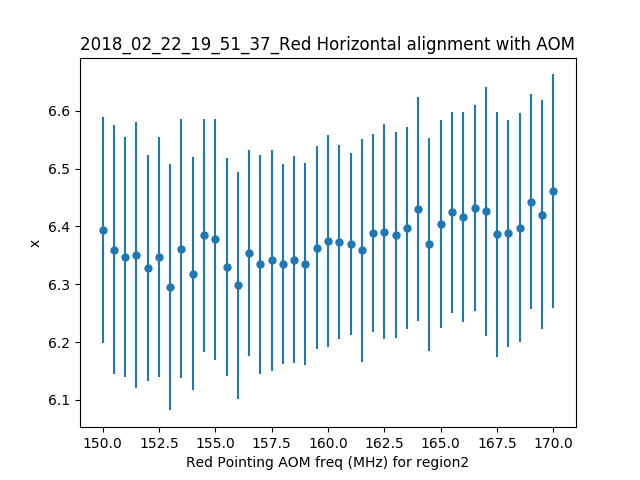

<IPython.core.display.Javascript object>


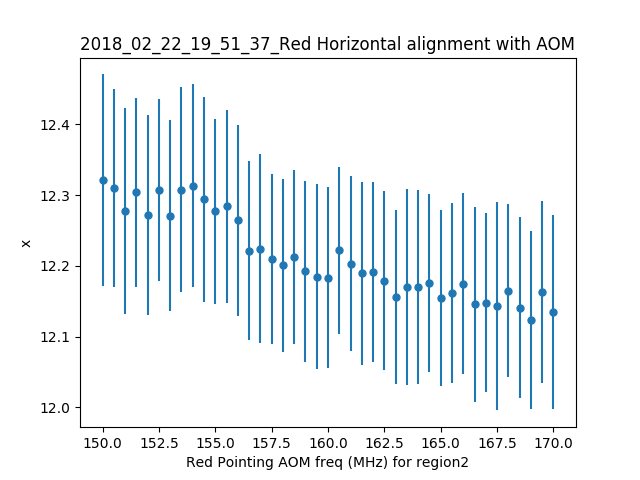

In [10]:
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = plt.subplots()
xdata = []
ydata = []
yerr = []
for e in range(len(np.squeeze(retention['ivar']))):
    xdata.append(np.squeeze(retention['ivar'])[e][2])
    ydata.append(q.experiments[0]['iterations'][e]['AAS_blueside']['x'])
    yerr.append(q.experiments[0]['iterations'][e]['AAS_blueside']['sigma_x'])
ax.errorbar(xdata,ydata,yerr=yerr,fmt='o',markersize=5)

plt.show()
ax.set_title(exp_id)
#ax.set_ylim(-10, 10)
ax.set_xlabel(xlab)
ax.set_ylabel('x')
ax.legend()

colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = plt.subplots()
xdata = []
ydata = []
yerr = []
for e in range(len(np.squeeze(retention['ivar']))):
    xdata.append(np.squeeze(retention['ivar'])[e][2])
    ydata.append(q.experiments[0]['iterations'][e]['AAS_blueside']['y'])
    yerr.append(q.experiments[0]['iterations'][e]['AAS_blueside']['sigma_y'])
ax.errorbar(xdata,ydata,yerr=yerr,fmt='o',markersize=5)

plt.show()
ax.set_title(exp_id)
#ax.set_ylim(-10, 10)
ax.set_xlabel(xlab)
ax.set_ylabel('x')
ax.legend()